### Initialization 

In [1]:
import pypsa
import pandas as pd
from BaseNetwork import BuildBaseNetwork
from silent_optimize import silent_optimize
import matplotlib.pyplot as plt
import numpy as np

# Task C

In [2]:
# Basemodel with DK
setup = {'DK': 
                {'OCGT': True,
                'solar': True,
                'offwind': True,
                'onwind': True},
                }

years = [2013, 2014, 2015, 2016, 2017]

network_year = {year: None for year in years}

generator_opt_year = {
    key: {
        'OCGT': [],
        'onwind': [],
        'offwind': [],
        'solar': [] }
    for key in setup.keys()}

objectives_year = []

for year in years:
    # Initialize the base network
    Network_Yearly = BuildBaseNetwork(year = year, cost_year = 2030, setup = setup, demand_year=2019)

    # Solve the network for the specific year
    # Network_Yearly.network.optimize(solver_name="gurobi",solver_options={"OutputFlag": 0})
    silent_optimize(Network_Yearly.network)

    network_year[year] = Network_Yearly.network

    # Extract the results
    objectives_year.append(Network_Yearly.network.objective)
    generators_year = Network_Yearly.network.generators.p_nom_opt.keys()
    for region in Network_Yearly.regions:
        for generator in generators_year:
            if generator.split(' ')[1] == region:
                generator_opt_year[region][generator.split(' ')[0]].append(Network_Yearly.network.generators.p_nom_opt[generator].sum())


Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 24.17it/s]


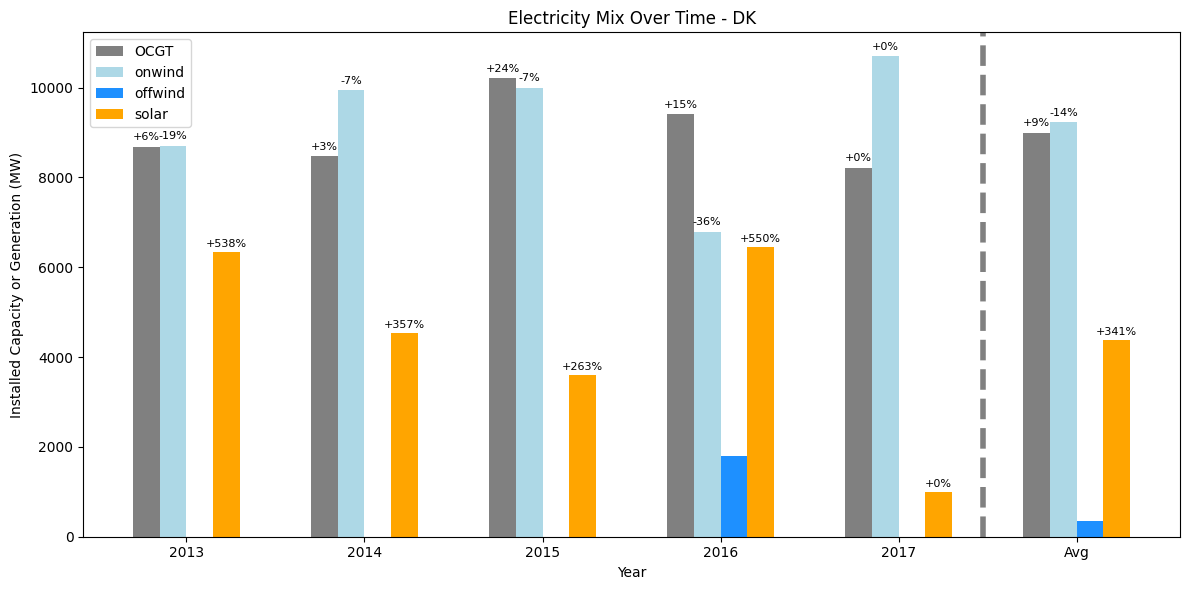

In [3]:
def plot_generation_mix_with_percentage_labels(years, generator_opt_year, base_year=2017):
    x = np.arange(len(years) + 1)  # One extra slot for 'Average'
    bar_width = 0.15

    for country, techs in generator_opt_year.items():
        plt.figure(figsize=(12, 6))

        for i, tech in enumerate(techs.keys()):
            values = techs.get(tech, [])
            if not values:
                continue

            # Get base value for normalization
            try:
                base_index = years.index(base_year)
                base_value = values[base_index]
            except (ValueError, IndexError):
                print(f"Warning: Base year {base_year} not found or no data for tech {tech}. Skipping label.")
                base_value = 0

            avg = np.mean(values)
            values_with_avg = values + [avg]

            bar_positions = x + i * bar_width
            bars = plt.bar(bar_positions, values_with_avg, width=bar_width, label=tech, color=colors_tab[tech])

            # Add percentage labels relative to base year
            for j, (bar, val) in enumerate(zip(bars, values_with_avg)):
                if base_value != 0:
                    pct_change = ((val - base_value) / base_value) * 100
                    label = f"{pct_change:+.0f}%"
                else:
                    label = ""  # Avoid division by zero

                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + max(values_with_avg) * 0.01,
                    label,
                    ha='center',
                    va='bottom',
                    fontsize=8
                )
        # Add vertical dotted line before 'Avg'
        split_position = x[-2] + bar_width * len(techs) + 0.1  # End of last year group

        plt.axvline(x=split_position , color='gray', linestyle='--', linewidth=4)

        xtick_labels = years + ['Avg']
        plt.xticks(x + bar_width * (len(techs.keys()) - 1) / 2, xtick_labels)

        plt.title(f"Electricity Mix Over Time - {country}")
        plt.xlabel("Year")
        plt.ylabel("Installed Capacity or Generation (MW)")
        plt.legend()
        plt.tight_layout()
        plt.show()
colors_tab = Network_Yearly.colors
plot_generation_mix_with_percentage_labels(years, generator_opt_year, base_year=2017)